In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import ClassicalRegister
from qiskit import QuantumRegister

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/tmp/ipykernel_146/3360342883.py:15: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [2]:
# Importing all the necessary libraries
from qiskit.circuit.library import IntegerComparator, GroverOperator, ZGate
from qiskit.quantum_info import Statevector
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

# Dataset, binary data and continuous data

In [3]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')

def packnbits(arr, axis=-1):
    '''pack bitstrings to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

In [4]:
def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import random
import math
from math import pi, sqrt

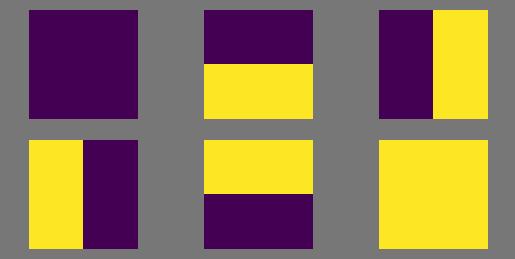

In [6]:
# Generating dataset 
geometry = (2,2) 
pl2 = barstripe_pdf(geometry)
# plt.plot(pl2)

# show ticks
basis = binary_basis(geometry)


# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (3, 3)
plot_bs(samples, size)

In [7]:
# Mapping between bars and stripes and their binary representation 
d0 = np.shape(samples)[0] #Number of possible combinations
d1 = np.shape(samples)[1] #Number of bars in one element
d2 = np.shape(samples)[2] #Number of stripes in one element 
bs = [] # Converting bars and stripes into numbers
for index in range(d0):
    sample_digit = np.reshape(samples[index], np.size(samples[index]))
    bs.append(sample_digit.dot(2**np.arange(sample_digit.size)[::-1]))
bs_bite  = np.array(["{0:04b}".format(x) for x in bs]) #binary representation of bars and stripes
print(bs_bite)

['0000' '0011' '0101' '1010' '1100' '1111']


# Dürr-Høyer algorithm

In [8]:
# Hamming distance for
def hamming_distance(str1, str2):
    """Calculate the Hamming distance between two bit strings
    """
    if len(str1) != len(str2):
        raise VisualizationError("Strings not same length.")
    return sum(s1 != s2 for s1, s2 in zip(str1, str2))

In [9]:
# Sepparating Bars & Stripes
bs = np.array(bs, dtype=int)
stripes = bs_bite[np.where((bs % 5 ==0) & (bs !=0))]
bars = np.setdiff1d(bs_bite, stripes)
print(bars)
print(stripes)

['0000' '0011' '1100']
['0101' '1010' '1111']


In [10]:
# Separate bars & stripes
import random
N = 4 # Test for N=4 qubits
y_bite = random.choice(bars) #Initial guess
# Circuit for a quantum solution
# qubit = QuantumRegister(N, 'q')
# bit = ClassicalRegister(y, "yc")
# durr_hoyer_circuit = QuantumCircuit(qubit, bit)

In [11]:
# Binary 
#y_bite = "{0:04b}".format(y) x_b = "{0:04b}".format(x)
x_b = random.choice(bs_bite) # Choose a vector x

In [12]:
# Distances
distances = []
for b in range(len(bs_bite)):
    distances.append(hamming_distance(x_b,bs_bite[b]))
print(distances)

[0, 2, 2, 2, 2, 4]


In [13]:
#Printing x and elements in a binary form
print(x_b,y_bite)
print(bs_bite)

0000 0011
['0000' '0011' '0101' '1010' '1100' '1111']


In [14]:
backend = Aer.get_backend('qasm_simulator')

In [15]:
#Dürr-Høyer algorithm 
max_iteration = int(22.5 * math.sqrt(d0) + 1.4 * math.log2(d0)) # max number of iterations
for k in range(max_iteration):  #max_iteration
    marked_items = [b for b in bars if hamming_distance(x_b,b) < hamming_distance(x_b,y_bite)] # marked elements 
    y_dash_bite = random.choice(marked_items) if len(marked_items) != 0 else y_bite
    oracle = Statevector.from_label(y_dash_bite)  # Using qiskit Grover operator
    problem = AmplificationProblem(oracle, is_good_state=(y_dash_bite))
    grover_circuits = [] # Circuit for the problem
    for iteration in range(1,3):
        grover = Grover(iterations=iteration)
        circuit = grover.construct_circuit(problem)
        circuit.measure_all()
        grover_circuits.append(circuit)
    results1 = execute(grover_circuits[1], backend, shots = 1024).result()
    counts1 = results1.get_counts()
    most_frequent_value = counts1.most_frequent()
    y_bite = y_dash_bite if hamming_distance(x_b,y_dash_bite) < hamming_distance(x_b,y_bite) else y_bite

In [16]:
min_element = int(y_bite, 2) 
min_index = np.where(bs==min_element)[0] 
print("The clostsest element to x =", min_element,"and x from bars " if hamming_distance(x_b,y_bite)==0 else "and x from stripes")

The clostsest element to x = 0 and x from bars 
